## Setup

In [1]:
import sys
import math
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def load_data(dataset_name):
    # Read the data and create the dataframe.
    df = pd.DataFrame(pd.read_csv(dataset_name, encoding='utf-8', sep=",", skiprows = 1, header=None))

    # Specify column names.
    df.columns = ['day', 'isweekend', 'weekday', 'periodofday', 'nr_bookings_period', 'weather', 'calls_period']

    # Convert the 'timestamp' column to date format.
    df['day'] = pd.to_datetime(df['day'], errors="raise")

    df.drop('calls_period', axis=1, inplace=True)
    
    df.dropna(inplace=True)

    return df.sort_values('day')


In [2]:
df = load_data("data/VancouverFullMidTerm.csv")

In [3]:
df.head()

,day,isweekend,weekday,periodofday,nr_bookings_period,weather
0,2017-01-02 00:00:00+00:00,False,Mon,1,106,3
1,2017-01-02 00:00:00+00:00,False,Mon,2,160,3
2,2017-01-02 00:00:00+00:00,False,Mon,3,348,7
3,2017-01-02 00:00:00+00:00,False,Mon,4,428,3
4,2017-01-02 00:00:00+00:00,False,Mon,5,470,3


## Data Preparation

In [4]:
# Convert weather to an integer identifier.
df['weather'] = df['weather'].apply(lambda x: int(x))

# Convert timestamp to an integer identifier of the day.
df['day_int'] = df['day'].apply(lambda x: x.toordinal())

# Extract day of the week and hour of the day.
df['dayofweek'] = df['day'].apply(lambda x: x.isoweekday())
df['hourofday'] = df['day'].apply(lambda x: x.hour)
df.drop('day', axis=1, inplace=True)

In [5]:
df.head()

,isweekend,weekday,periodofday,nr_bookings_period,weather,day_int,dayofweek,hourofday
0,False,Mon,1,106,3,736331,1,0
1,False,Mon,2,160,3,736331,1,0
2,False,Mon,3,348,7,736331,1,0
3,False,Mon,4,428,3,736331,1,0
4,False,Mon,5,470,3,736331,1,0


In [6]:
df.head()

,isweekend,weekday,periodofday,nr_bookings_period,weather,day_int,dayofweek,hourofday
0,False,Mon,1,106,3,736331,1,0
1,False,Mon,2,160,3,736331,1,0
2,False,Mon,3,348,7,736331,1,0
3,False,Mon,4,428,3,736331,1,0
4,False,Mon,5,470,3,736331,1,0


In [7]:
# One-hot encode categorical columns.
def one_hot_column(df, column_name):
    dummies = pd.get_dummies(df[column_name]).values.tolist()
    df.drop(column_name, axis=1, inplace=True)
    df[column_name] = dummies
    return df

df = one_hot_column(df, 'dayofweek')
df = one_hot_column(df, 'periodofday')
df = one_hot_column(df, 'weather')

In [8]:
# Number of days.
print(len(set(df['day_int'])))

166


In [9]:
# Divide the dataset into train and test sets.
# Last week of data is for testing.
max_day = max(df['day_int'].tolist())
df_train = df[df['day_int'] <= max_day - 90]
df_test = df[df['day_int'] > max_day - 90]

In [10]:
df_train.head()

,isweekend,weekday,nr_bookings_period,day_int,hourofday,dayofweek,periodofday,weather
0,False,Mon,106,736331,0,"[1, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,False,Mon,160,736331,0,"[1, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,False,Mon,348,736331,0,"[1, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
3,False,Mon,428,736331,0,"[1, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,False,Mon,470,736331,0,"[1, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [11]:
print(len(df_train), len(df_test))

693 469


In [12]:
df_train = df_train.drop(columns=['isweekend', 'weekday', 'day_int', 'hourofday'])
df_train.head()

,nr_bookings_period,dayofweek,periodofday,weather
0,106,"[1, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,160,"[1, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,348,"[1, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
3,428,"[1, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,470,"[1, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [13]:
df_test = df_test.drop(columns=['isweekend', 'weekday', 'day_int', 'hourofday'])
df_test.head()

,nr_bookings_period,dayofweek,periodofday,weather
693,251,"[0, 1, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
694,775,"[0, 1, 0, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
695,606,"[0, 1, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
696,656,"[0, 1, 0, 0, 0, 0, 0]","[0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
697,1016,"[0, 1, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [14]:
print(len(df_train), len(df_test))

693 469


In [15]:
# WARNING: This was the previous implementation of the function that
# generates the data in the correct format for the models.
# However, the way I first implemented it, it was including the
# variable we wanted to predict in the set of features used for prediction.
# Below you will find a correct version of this function.
# I kept the wrong implementation here in case someone wants to check that
# it indeed produced the results I reported in the slides.
def to_sequence_wrong(df):
    x = []
    y = [] 
    observations = []
    for _, row in df.iterrows():
        observations.append([row['nr_bookings_period']] + row['dayofweek'] + row['periodofday'] + row['weather'])
    for j in range(len(observations)):
        window = [observations[j]]
        window = [x for x in window]
        x.append(window)
        y.append(window[0][0])
    return np.array(x), np.array(y)

In [16]:
def to_sequence(df):
    x = []
    y = [] 
    observations = []
    for _, row in df.iterrows():
        observations.append([row['nr_bookings_period']] + row['dayofweek'] + row['periodofday'] + row['weather'])
    for j in range(len(observations)):
        window = [observations[j]]
        y.append(window[0][0])
        window = [x[1:] for x in window]
        x.append(window)
        
    return np.array(x), np.array(y)


In [17]:
x_train, y_train = to_sequence(df_train)
x_test, y_test = to_sequence(df_test)

In [18]:
print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))

Shape of training set: (693, 1, 43)
Shape of test set: (469, 1, 43)


In [19]:
# Print a pair features (x_train) and corresponding number of bookings (y_train)
print(x_train[0], y_train[0])

[[1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0]] 106


In [20]:
# Print a pair features (x_test) and corresponding number of bookings (y_test)
print(x_test[0], y_test[0])

[[0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0]] 251


In [21]:
print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))

x_train = x_train.reshape((x_train.shape[0], 43))
x_test = x_test.reshape((x_test.shape[0], 43))

print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))

Shape of training set: (693, 1, 43)
Shape of test set: (469, 1, 43)
Shape of training set: (693, 43)
Shape of test set: (469, 43)


In [33]:
# Standard ML Models for comparison
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

# Splitting data into training/testing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Auto ARIMA model
import pmdarima as pm

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

# Distributions
import scipy
from collections import defaultdict


def evaluate(x_train, x_test, y_train, y_test):
    # Instantiate the models
    linear_regression = LinearRegression(fit_intercept=False, normalize=True)
    elastic_net = ElasticNet(alpha=1.0, l1_ratio=0.5)
    random_forest = RandomForestRegressor(n_estimators=50)
    extra_trees = ExtraTreesRegressor(n_estimators=50)
    svr = SVR(kernel='rbf', degree=3, C=1.0, gamma='auto')
    gradient_boosting = GradientBoostingRegressor(n_estimators=20)
    arima_train = np.array([[float(item[0])] for item in x_train])  
    arima = pm.auto_arima([x for x in arima_train], start_p=0, start_q=0, max_p=2, max_q=2, m=7,
                             start_P=0, max_P=2, seasonal=True, d=0, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

    #arima = pm.ARIMA(order=(2, 0, 2), seasonal_order=(0, 1, 0, 7))
    model_name_list = ['Linear Regression', 'ElasticNet Regression', 'Random Forest', 'Extra Trees', 'SVM', 'Gradient Boosted', 'ARIMA', 'Baseline']
    models_list = [linear_regression, elastic_net, random_forest, extra_trees, svr, gradient_boosting, arima]
    evaluation_results = {name:{'predictions':[], 'actual_values':[]} for name in model_name_list}

    # Mean value: baseline metric
    evaluation_results['Baseline']['predictions'].extend([np.mean(y_train)] * len(y_test))
    evaluation_results['Baseline']['actual_values'].extend(y_test)
    
    # Train and predict with each model
    for i, model in enumerate(models_list):
        print("Evaluating model {}".format(model_name_list[i]))

        if i == len(models_list) - 1:
            arima_train = np.array([[float(item[0])] for item in x_train])
            fit = model.fit(x = arima_train, y = y_train)
            predictions = fit.predict(n_periods = x_test.shape[0])
        else:
            fit = model.fit(x_train, y_train)
            predictions = fit.predict(x_test)
        evaluation_results[model_name_list[i]]['predictions'] = predictions
        evaluation_results[model_name_list[i]]['actual_values'] = y_test
    

    return evaluation_results


In [34]:
results = evaluate(x_train, x_test, y_train, y_test)

Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 1, 7); AIC=544.990, BIC=558.583, Fit time=0.870 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 2, 7); AIC=520.154, BIC=538.278, Fit time=1.850 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 1, 1, 7); AIC=532.854, BIC=550.978, Fit time=1.231 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 1, 2, 7); AIC=543.965, BIC=566.619, Fit time=0.725 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(2, 1, 1, 7); AIC=514.699, BIC=537.354, Fit time=2.228 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(2, 1, 2, 7); AIC=533.589, BIC=560.775, Fit time=2.694 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 7); AIC=76.797, BIC=94.920, Fit time=1.230 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 2, 7); AIC=-17.300, BIC=5.354, Fit time=3.053 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 1, 1, 7); AIC=34.811, BIC=57.465, Fit time=1.218 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 1, 2, 7); AIC=-

In [35]:
for k, _ in results.items():
    model_name = k
    print("Model: ", model_name)
    yhat = np.array(results[model_name]['predictions'])
    y = np.array(results[model_name]['actual_values'])
    mape = []
    mae = []
    for i in range(len(results[model_name]['actual_values'])):
        mape.append(np.fabs((y[i] - yhat[i]) / y[i]) * 100)
        mae.append(np.fabs((y[i] - yhat[i])))
    print(np.min(mape), np.mean(mape), np.max(mape), np.std(mape))
    print()

Model:  Linear Regression
0.040040059575902176 21.62553925554414 137.72976764283368 17.21352845239687

Model:  ElasticNet Regression
0.12911646201109894 35.62474353462963 157.66000624050108 34.42024073781326

Model:  Random Forest
0.0838603425559926 15.289129026406329 148.6256564583702 10.871236226730392

Model:  Extra Trees
0.062176165803099384 15.28630541571266 197.6654275092937 12.924021599163206

Model:  SVM
0.015995361390219204 41.39326240971196 202.64251097974815 42.81277476310404

Model:  Gradient Boosted
0.040690577439131584 20.28418366291241 131.4125870567132 15.866916296338502

Model:  ARIMA
0.02599669548447077 52.44503076042342 332.7969436645985 70.65403454111446

Model:  Baseline
0.11611817779218753 41.74986405128773 207.7869842575725 44.010382199783905



# Neural Network

In [218]:
x_train, y_train = to_sequence(df_train)
x_test, y_test = to_sequence(df_test)

In [219]:
print(x_train.shape, y_train.shape)

(693, 1, 43) (693,)


In [220]:
print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))

x_train = x_train.reshape((x_train.shape[0], 1, 43))
x_test = x_test.reshape((x_test.shape[0], 1, 43))

print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))

Shape of training set: (693, 1, 43)
Shape of test set: (469, 1, 43)
Shape of training set: (693, 1, 43)
Shape of test set: (469, 1, 43)


In [221]:
import tensorflow as tf
import keras

print(tf.__version__)
print(keras.__version__)

1.13.1
2.2.4


In [227]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.datasets import imdb
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np


def evaluate_neural_net(x_train, x_test, y_train, y_test):
    print('Build model...')
    model = Sequential()
    model.add(LSTM(64, dropout = 0.0, recurrent_dropout = 0.0, input_shape=(1, 43)))
    model.add(Dense(4))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience = 50, verbose = 0, mode='auto', restore_best_weights=True)
    history = model.fit(x_train, y_train, validation_data = (x_test, y_test), callbacks = [monitor], verbose = 2, epochs = 300)
    return model, history

In [228]:
model, history = evaluate_neural_net(x_train, x_test, y_train, y_test)

Build model...
Train on 693 samples, validate on 469 samples
Epoch 1/300
 - 1s - loss: 680.0321 - val_loss: 807.9405
Epoch 2/300
 - 0s - loss: 679.5518 - val_loss: 807.3283
Epoch 3/300
 - 0s - loss: 678.7119 - val_loss: 806.2241
Epoch 4/300
 - 0s - loss: 677.2304 - val_loss: 804.3463
Epoch 5/300
 - 0s - loss: 674.8156 - val_loss: 801.4314
Epoch 6/300
 - 0s - loss: 671.2042 - val_loss: 797.2424
Epoch 7/300
 - 0s - loss: 666.2023 - val_loss: 791.6395
Epoch 8/300
 - 0s - loss: 659.6877 - val_loss: 784.5064
Epoch 9/300
 - 0s - loss: 651.5768 - val_loss: 775.8013
Epoch 10/300
 - 0s - loss: 641.8234 - val_loss: 765.4741
Epoch 11/300
 - 0s - loss: 630.3745 - val_loss: 753.4777
Epoch 12/300
 - 0s - loss: 617.1728 - val_loss: 739.7131
Epoch 13/300
 - 0s - loss: 602.1329 - val_loss: 724.1534
Epoch 14/300
 - 0s - loss: 585.2057 - val_loss: 706.7065
Epoch 15/300
 - 0s - loss: 566.3511 - val_loss: 687.3649
Epoch 16/300
 - 0s - loss: 545.7319 - val_loss: 666.4878
Epoch 17/300
 - 0s - loss: 524.4289 

In [229]:
from sklearn import metrics

def get_rmse(x_test, y_test, model):
    pred = model.predict(x_test)
    pred = pred.astype('int')
    score = np.sqrt(metrics.mean_squared_error(pred, y_test))
    return score

def get_mae(x_test, y_test, model):
    pred = model.predict(x_test)
    pred = pred.astype('int')
    score = metrics.mean_absolute_error(pred, y_test)
    return score

def get_mape(x_test, y_test, model):
    pred = model.predict(x_test)
    pred = pred.astype('int')
    mape = []
    for i in range(len(pred)):
        mape.append(np.fabs((y_test[i] - pred[i][0]) / y_test[i]) * 100)
    return (min(mape), np.mean(mape), max(mape), np.std(mape))

score = get_rmse(x_test, y_test, model)
print("Score (RMSE): {}".format(score))

score = get_mae(x_test, y_test, model)
print("Score (MAE): {}".format(score))

score = get_mape(x_test, y_test, model)
print("Score (MAPE): {}".format(score))


Score (RMSE): 181.18506483303227
Score (MAE): 143.18336886993603
Score (MAPE): (0.0, 18.14833327337994, 111.14864864864865, 14.058349594376395)


In [231]:
def plot_pred(y_test, pred, figname):
    plt.figure()
    plt.plot(y_test, linestyle="-")
    plt.plot(pred, linestyle="--")
    plt.title('Predictions')
    plt.ylabel('Number of Bookings')
    plt.xlabel('Test Instance')
    plt.legend(['y_test', 'pred'], loc='best')
    plt.savefig(figname + ".pdf", format='pdf', dpi=150)
    plt.show()

In [232]:
pred = model.predict(x_test)

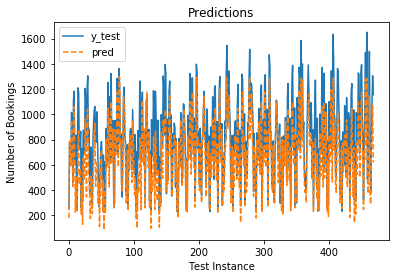

In [233]:
plot_pred(y_test, pred, "charts/NeuralNetPredictionStationary")

In [234]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 64)                27648     
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 260       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 5         
Total params: 27,913
Trainable params: 27,913
Non-trainable params: 0
_________________________________________________________________
